# Neural Network model development
Created by Ivan Lima on Wed Nov 10 2021 11:10:06 -0500

In this notebook we develop a neural network model to predict DIC and TA from the merged bottle and satellite data using pytorch.

This version of the neural network model does not include dissolved oxygen as an input feature.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, joblib
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Fri Dec 10 11:05:09 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Read merged bottle satellite data 

In [3]:
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)

## Select input features and split data into training and test sets 

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X_numpy = df[features].values
Y_numpy = df[targets].values

# Split data into training and test sets
X_numpy_train, X_numpy_test, Y_numpy_train, Y_numpy_test = train_test_split(X_numpy, Y_numpy, random_state=42)

### Correlation between feature and target variables 

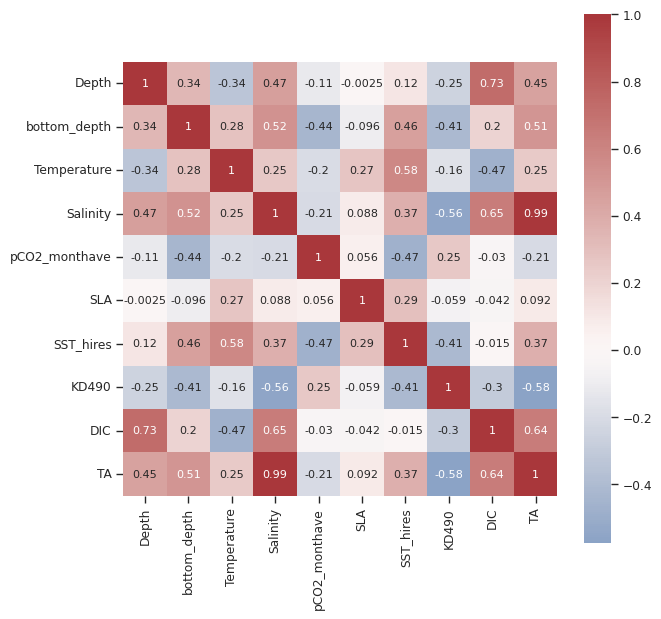

In [5]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

## Rescale data 

Neural networks are very sensitive to the scale and distribution of each feature. Therefore, we rescale input features so they have $\overline{x}=0$ and $\sigma=1$.

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler().fit(X_numpy_train)
X_numpy_train_scaled = scaler.transform(X_numpy_train)
X_numpy_test_scaled = scaler.transform(X_numpy_test)
X_numpy_scaled = scaler.transform(X_numpy)

## Neural Network regression 

In [7]:
import torch
import torch.nn as nn

# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device

# convert numpy arrays to pytorch tensors
X_train = torch.from_numpy(X_numpy_train_scaled.astype(np.float32))
Y_train = torch.from_numpy(Y_numpy_train.astype(np.float32))
# print('X size: {}\nY size: {}'.format(X_train.size(), Y_train.size()))

# set neural network parameters
n_features = X_train.size()[1] # number of input variables
n_targets = Y_train.size()[1]  # number of output variables
n_hidden = 256                 # number of hidden layers
learning_rate = 0.001

torch.manual_seed(42) # set random number seed to make things reproducible

# create neural network regression model
class MLPReg(nn.Module):
    def __init__(self, n_features, n_hidden, n_targets):
        super(MLPReg, self).__init__()
        self.l1    = nn.Linear(n_features, n_hidden)
        self.l2    = nn.Linear(n_hidden, n_hidden)
        self.l3    = nn.Linear(n_hidden, n_targets)
        self.activ = nn.LeakyReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.activ(out)
        out = self.l2(out)
        out = self.activ(out)
        out = self.l3(out)
        return out

nn_reg = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets) # create model instance
print(nn_reg)

loss_func = nn.MSELoss()                                                      # loss function (mean square error)
optimizer = torch.optim.Adam(nn_reg.parameters(), lr=learning_rate)           # optimizer

loss_vals = [] # keep loss function values for plotting

# train the model
n_passes = 35000
for n in range(n_passes):
    # forward pass
    prediction = nn_reg(X_train)
    loss = loss_func(prediction, Y_train)
    # backward pass
    optimizer.zero_grad()   # clear accumulated gradients for next pass
    loss.backward()         # do backpropagation to compute gradients
    optimizer.step()        # apply gradients to update parameters
    loss_vals.append(loss.item())
    if (n==0) or ((n+1) % 1000 == 0):
        print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, n_passes, loss.item()))

MLPReg(
  (l1): Linear(in_features=8, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
  (activ): LeakyReLU(negative_slope=0.01)
)
pass     1/35000, MSE=4726825.00
pass  1000/35000, MSE=30960.42
pass  2000/35000, MSE=5206.81
pass  3000/35000, MSE=615.09
pass  4000/35000, MSE=247.15
pass  5000/35000, MSE=209.38
pass  6000/35000, MSE=186.67
pass  7000/35000, MSE=167.63
pass  8000/35000, MSE=149.58
pass  9000/35000, MSE=130.90
pass 10000/35000, MSE=114.34
pass 11000/35000, MSE=102.00
pass 12000/35000, MSE=93.83
pass 13000/35000, MSE=84.52
pass 14000/35000, MSE=79.84
pass 15000/35000, MSE=75.15
pass 16000/35000, MSE=70.55
pass 17000/35000, MSE=66.07
pass 18000/35000, MSE=63.69
pass 19000/35000, MSE=61.62
pass 20000/35000, MSE=58.98
pass 21000/35000, MSE=57.24
pass 22000/35000, MSE=54.06
pass 23000/35000, MSE=52.30
pass 24000/35000, MSE=50.23
pass 25000/35000, MSE=48.92
pass 26000/35000, MSE=

### Loss function as function of number of passes

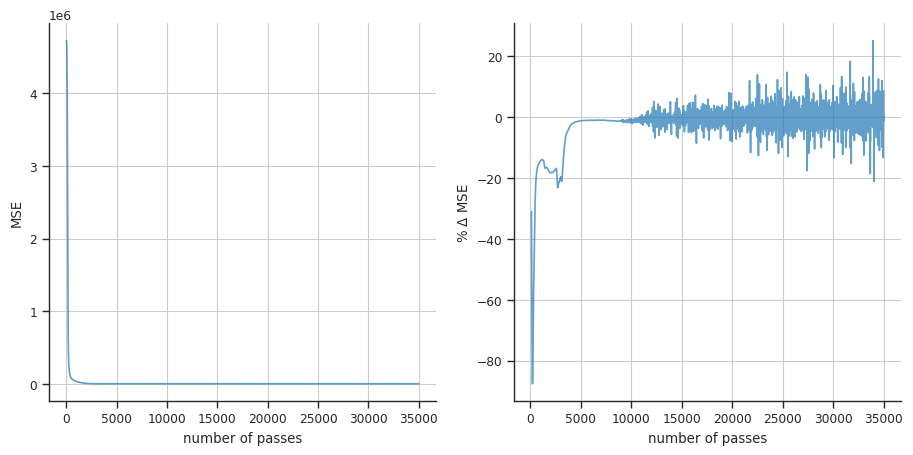

In [8]:
df = pd.DataFrame({'MSE': np.array(loss_vals)})
df['pct_change'] = df.MSE.pct_change(100) * 100
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = df.MSE.plot(ax=axs[0], alpha=0.7, legend=False)
_ = df['pct_change'].plot(ax=axs[1], alpha=0.7, legend=False)
_ = axs[0].set(ylabel='MSE', xlabel='number of passes')
_ = axs[1].set(ylabel=r'% $\Delta$ MSE', xlabel='number of passes')
sns.despine(fig)

### Evaluate model on test set

In [9]:
from sklearn.metrics import r2_score

X_test = torch.from_numpy(X_numpy_test_scaled.astype(np.float32))
with torch.no_grad():
    Y_pred_train = nn_reg(X_train)
    Y_pred_test  = nn_reg(X_test)

print('Training set R squared: {:.3f}'.format(r2_score(Y_pred_train, Y_numpy_train)))
print('Test set R squared:     {:.3f}'.format(r2_score(Y_pred_test, Y_numpy_test)))

Training set R squared: 0.992
Test set R squared:     0.951


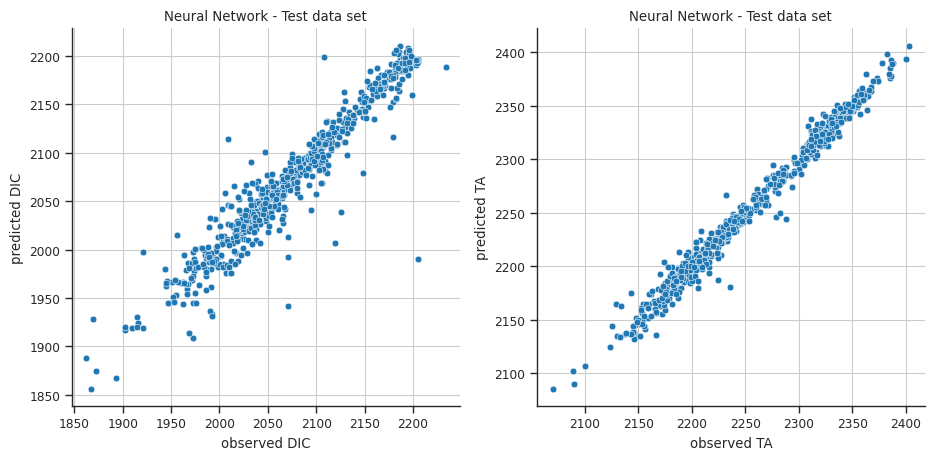

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.scatterplot(x=Y_numpy_test[:,0], y=Y_pred_test[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_numpy_test[:,1], y=Y_pred_test[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network - Test data set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network - Test data set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

### Save model and scaler for later use

In [11]:
joblib.dump(scaler, 'models/scaler.joblib') 
torch.save(nn_reg, 'models/nn_reg_noO2.pth')
torch.save(nn_reg.state_dict(), 'models/nn_reg_noO2_state.pth')

### Do k-fold cross-validation

In [12]:
torch.manual_seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

nnr_model = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets)

loss_func = nn.MSELoss() # loss function (mean square error)
optimizer = torch.optim.Adam(nnr_model.parameters(), lr=learning_rate) # optimizer

score_vals = [] # store score values

for k, (train_idx, test_idx) in enumerate(kf.split(X_numpy)):
    # rescale input data
    X_tr, X_te = X_numpy[train_idx], X_numpy[test_idx]
    ss = StandardScaler().fit(X_tr)
    X_tr_sc = ss.transform(X_tr)
    X_te_sc = ss.transform(X_te)
    
    # convert numpy arrays to tensors
    X = torch.from_numpy(X_tr_sc.astype(np.float32))
    Y = torch.from_numpy(Y_numpy[train_idx].astype(np.float32))

    # reset model weights to avoid weight leakage
    nnr_model.apply(reset_weights)
    
    # train the model
    ntot = n_passes
    for n in range(ntot):
        # forward pass
        prediction = nnr_model(X)
        loss = loss_func(prediction, Y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (n==0) or ((n+1) % 1000 == 0):
            print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, ntot, loss.item()))
    
    # evaluate model
    xx = torch.from_numpy(X_te_sc.astype(np.float32))
    with torch.no_grad():
        Y_pred  = nnr_model(xx)
        score = r2_score(Y_pred, Y_numpy[test_idx])
        score_vals.append(score)
        print('Fold {} test set R squared: {:.3f}\n'.format(k+1, score))

Reset trainable parameters of layer = Linear(in_features=8, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=2, bias=True)
pass     1/35000, MSE=4726655.50
pass  1000/35000, MSE=32616.55
pass  2000/35000, MSE=6092.06
pass  3000/35000, MSE=1003.78
pass  4000/35000, MSE=328.26
pass  5000/35000, MSE=225.64
pass  6000/35000, MSE=197.24
pass  7000/35000, MSE=175.83
pass  8000/35000, MSE=157.84
pass  9000/35000, MSE=140.70
pass 10000/35000, MSE=126.68
pass 11000/35000, MSE=113.99
pass 12000/35000, MSE=104.74
pass 13000/35000, MSE=97.53
pass 14000/35000, MSE=91.00
pass 15000/35000, MSE=85.76
pass 16000/35000, MSE=80.81
pass 17000/35000, MSE=78.11
pass 18000/35000, MSE=74.87
pass 19000/35000, MSE=71.99
pass 20000/35000, MSE=69.79
pass 21000/35000, MSE=67.22
pass 22000/35000, MSE=65.50
pass 23000/35000, MSE=64.39
pass 24000/35000, MSE=63.51
pass 25000

In [13]:
scores = np.array(score_vals)
with np.printoptions(precision=3, suppress=True):
    print('K-fold cross-validation (k=5) R squared values = {}'.format(scores))
print('Best R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

K-fold cross-validation (k=5) R squared values = [0.961 0.948 0.954 0.962 0.95 ]
Best R squared:  0.962
Worst R squared: 0.948
Mean R squared:  0.955


### Version using LBFGS optimizer (quasi-Newton method) and ReLU

The LBFGS optimizer is a slower and more computationaly expensive method that works well for smaller data sets. 

In [14]:
torch.manual_seed(42)

# create neural network regression model
class MLPReg2(nn.Module):
    def __init__(self, n_features, n_hidden, n_targets):
        super(MLPReg2, self).__init__()
        self.l1   = nn.Linear(n_features, n_hidden)
        self.l2   = nn.Linear(n_hidden, n_hidden)
        self.l3   = nn.Linear(n_hidden, n_targets)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

nnreg = MLPReg2(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets)
print(nnreg)

l_func = nn.MSELoss()                                              # loss function (mean square error)
opt_func = torch.optim.LBFGS(nnreg.parameters(), lr=learning_rate) # optimizer

# closure function for LBFGS optimizer
def closure():
    opt_func.zero_grad()
    ypred = nnreg(X_train)
    lf = loss_func(ypred, Y_train)
    lf.backward()
    return lf

# train the model
n_passes2 = 600
for n in range(n_passes2):
    # forward pass
    prediction = nnreg(X_train)
    loss = l_func(prediction, Y_train)
    # backward pass
    opt_func.zero_grad()   # clear gradients for next pass
    loss.backward()        # do backpropagation to compute gradients
    opt_func.step(closure) # apply gradients to update parameters
    if (n==0) or ((n+1) % 10 == 0):
        print('pass {:3d}/{}, MSE={:.2f}'.format(n+1, n_passes2, loss.item()))

MLPReg2(
  (l1): Linear(in_features=8, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
)
pass   1/600, MSE=4726820.00
pass  10/600, MSE=4602886.00
pass  20/600, MSE=600906.38
pass  30/600, MSE=99297.99
pass  40/600, MSE=35611.57
pass  50/600, MSE=15705.36
pass  60/600, MSE=7966.51
pass  70/600, MSE=7798.78
pass  80/600, MSE=6011.51
pass  90/600, MSE=4686.81
pass 100/600, MSE=3726.57
pass 110/600, MSE=3002.48
pass 120/600, MSE=2450.51
pass 130/600, MSE=2047.00
pass 140/600, MSE=1759.42
pass 150/600, MSE=1539.89
pass 160/600, MSE=1374.42
pass 170/600, MSE=1215.13
pass 180/600, MSE=1181.15
pass 190/600, MSE=1126.57
pass 200/600, MSE=1071.99
pass 210/600, MSE=1041.71
pass 220/600, MSE=1736.11
pass 230/600, MSE=1412.72
pass 240/600, MSE=1200.60
pass 250/600, MSE=1058.46
pass 260/600, MSE=961.25
pass 270/600, MSE=892.61
pass 280/600, MSE=843.56
pass 290/600, MSE=798.74
pass 3

### Evaluate model on test set

In [15]:
with torch.no_grad():
    Y_pred_train2 = nnreg(X_train)
    Y_pred_test2  = nnreg(X_test)

print('Training set R squared: {:.3f}'.format(r2_score(Y_pred_train2, Y_numpy_train)))
print('Test set R squared:     {:.3f}'.format(r2_score(Y_pred_test2, Y_numpy_test)))

Training set R squared: 0.946
Test set R squared:     0.936
